# Network inference notebook
This notebook is used to infer the networks using the following data-driven techniques:
1. The graphical lasso (input: raw data)
2. The influence model (input: activity states)
3. The interaction model (input: activity states

Copyright (C) 2020  Andrew Sonta, Rishee K. Jain

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import os
import copy
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%load_ext rpy2.ipython
import src.__init__ as init
timestep = init.TIME_STEP
timesteps = int(1440/timestep)

# Set fonts for plotting

# font_path = 'MyriadPro-Regular.otf'
# prop = fm.FontProperties(fname=font_path)
# matplotlib.rcParams['font.family'] = prop.get_name()

font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)

/usr/local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


## Infer network with graphical lasso

Here, we use the glasso package available in R to infer the network from the classified data.

/usr/local/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: sysfonts

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: showtextdb

  warnings.warn(x, RRuntimeWarning)


[1] 0.4313725


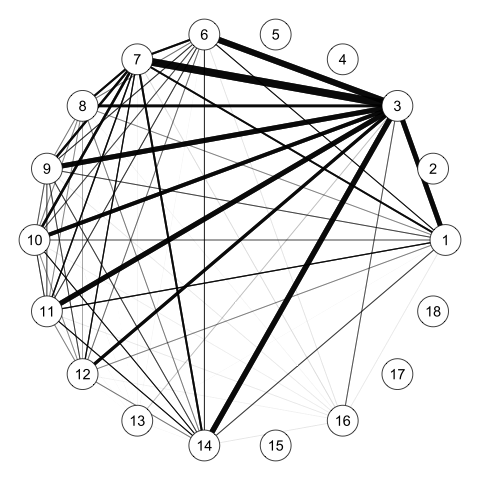

In [132]:
%%R
library(glasso)
library(igraph)

# This will only work if Myriad Pro is installed
# library(showtext)
# font_add("MyriadPro",
#     regular = "MyriadPro-Regular.otf",
#     bold = "MyriadPro-Bold.otf")
# showtext_auto()

# Use Arial instead
library(showtext)
font_add("Arial", "Arial.ttf")
showtext_auto()

# Load data
data <- read.csv('data/clean-berkeley.csv', header=TRUE,
                 colClasses=c("NULL",NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA))

# Set hyperparameter 'rho' so that the inferred network is a reasonable density
# Can experiment with multiple values within the rholist variable
rholist = c(450)
data_glasso <- glassopath(cov(data), rholist=rholist, trace=0)
glasso_adjs <- data_glasso$w

# Infer and plot network
for (i in 1:length(rholist)) {
    glasso_adj <- glasso_adjs[,,i]
    glasso_graph <- graph_from_adjacency_matrix(glasso_adj, mode='directed', weighted=TRUE)
    glasso_graph <- simplify(glasso_graph)
    lo <- layout.circle(glasso_graph)
    # png(width=1000, height=1000, res=150, file='glasso.png')
    par(mar=c(0.1,0.1,0.1,0.1))
    plot(glasso_graph, layout=lo, edge.width=E(glasso_graph)$weight/50, 
         vertex.label.cex=1.2,
         vertex.label.family='Arial',
         vertex.label.color='black',
         vertex.color='white',
         vertex.frame.color='black',
         edge.color=adjustcolor('black',.8),
         edge.arrow.mode=0)
}
print(edge_density(glasso_graph))

# Write glasso network as adjacency matrix in .csv file
# write.csv(as_adj(glasso_graph, attr='weight', sparse=FALSE), 'data/graphs/glasso-adj.csv', row.names=FALSE)

## Infer network with influence model (need Matlab)

First, we need to save the data in the right format for the influence model

In [19]:
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0).values[:,:18]
classified = classified.T
np.savetxt('data/classified-berkeley_influence.csv', classified, delimiter=',', fmt='%i')

The following code assumes we have inferred the network using the influence model and it is saved in `data/graphs/influence.csv`

In [2]:
%%R
library(igraph)
influence_adj <- read.csv('data/graphs/influence.csv', header=FALSE)
colnames(influence_adj) <- 1:18
influence_graph <- graph_from_adjacency_matrix(as.matrix(influence_adj), mode='undirected', weighted=TRUE)

# Only delete edges for plotting purposes!
# Comment following lines when saving the full graph
# influence_graph <- delete_edges(influence_graph, E(influence_graph)[weight<0.01])
# print(edge_density(influence_graph))

lo <- layout.circle(influence_graph)

# When plotting the graph, use the threshold line above
# png(width=1000, height=1000, res=150, file='influence.png')
par(mar=c(0.1,0.1,0.1,0.1))
plot(influence_graph, layout=lo, edge.width=E(influence_graph)$weight*175,
     vertex.label.cex=1.2,
     vertex.label.family='MyriadPro',
     vertex.label.color='black',
     vertex.color='white',
     vertex.frame.color='black',
     edge.color=adjustcolor('black',.8),
     edge.arrow.mode=0)

# Make sure when saving the graph, the edges have not been deleted above
write.csv(as_adj(influence_graph, attr='weight', sparse=FALSE), 'data/graphs/influence-adj.csv', row.names=FALSE)

## Infer network with interaction model

This part of the code makes use of the `interaction_model` module in the `src` file

### Test on a single day for visualization

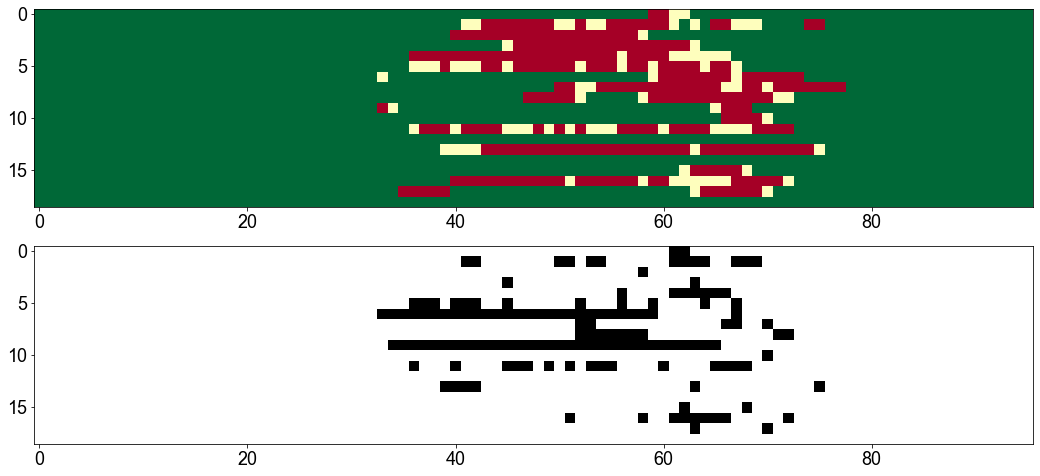

Overlaps between occupants 1 and 2
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.15384615 0.15384615 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [104]:
import src.interaction_model as im

# Import data
start = '2019-01-22 00:00:00'
end =   '2019-01-22 24:00:00'
classified = pd.read_csv('data/classified-berkeley.csv', index_col=0)
vectordata = classified.loc[start:end]

# Get list of occupant names AKA column names
occupants = list(classified.columns)
opportunity_vecs = []
# Create opportunity vector for each occupant
for occupant in occupants:
    vec = im.fill_opp_vec(vectordata[occupant].values)
    opportunity_vecs.append(vec)
    
# Visualize classified data and opportunity vectors
fig = plt.figure(figsize=(27,8))
ax1 = fig.add_subplot(2,1,1)
plt.imshow(np.transpose(vectordata), aspect=1.0, cmap="RdYlGn_r")
ax2 = fig.add_subplot(2,1,2)
plt.imshow(opportunity_vecs, aspect=1.0, cmap="gray_r")
plt.show()

testoverlaps = np.zeros((19, 19, 96))
i=0
for vec1 in opportunity_vecs:
    j=0
    for vec2 in opportunity_vecs:
        intersection = 0
        if vec1 is not vec2:
            for k in range(len(vec1)):
                if vec1[k] == 1 and vec2[k] == 1:
                    intersection += 1.0
            similarity = intersection/(sum(vec1) + sum(vec2) - intersection)
            for k in range(len(vec1)):
                if vec1[k] == 1 and vec2[k] == 1:
                    testoverlaps[i,j,k] += 1.0*similarity
        j += 1
    i += 1
print('Overlaps between occupants 1 and 2')
print(testoverlaps[0][1])

### Create heatmap of each occupants' opportunity for interaction over the chosen day

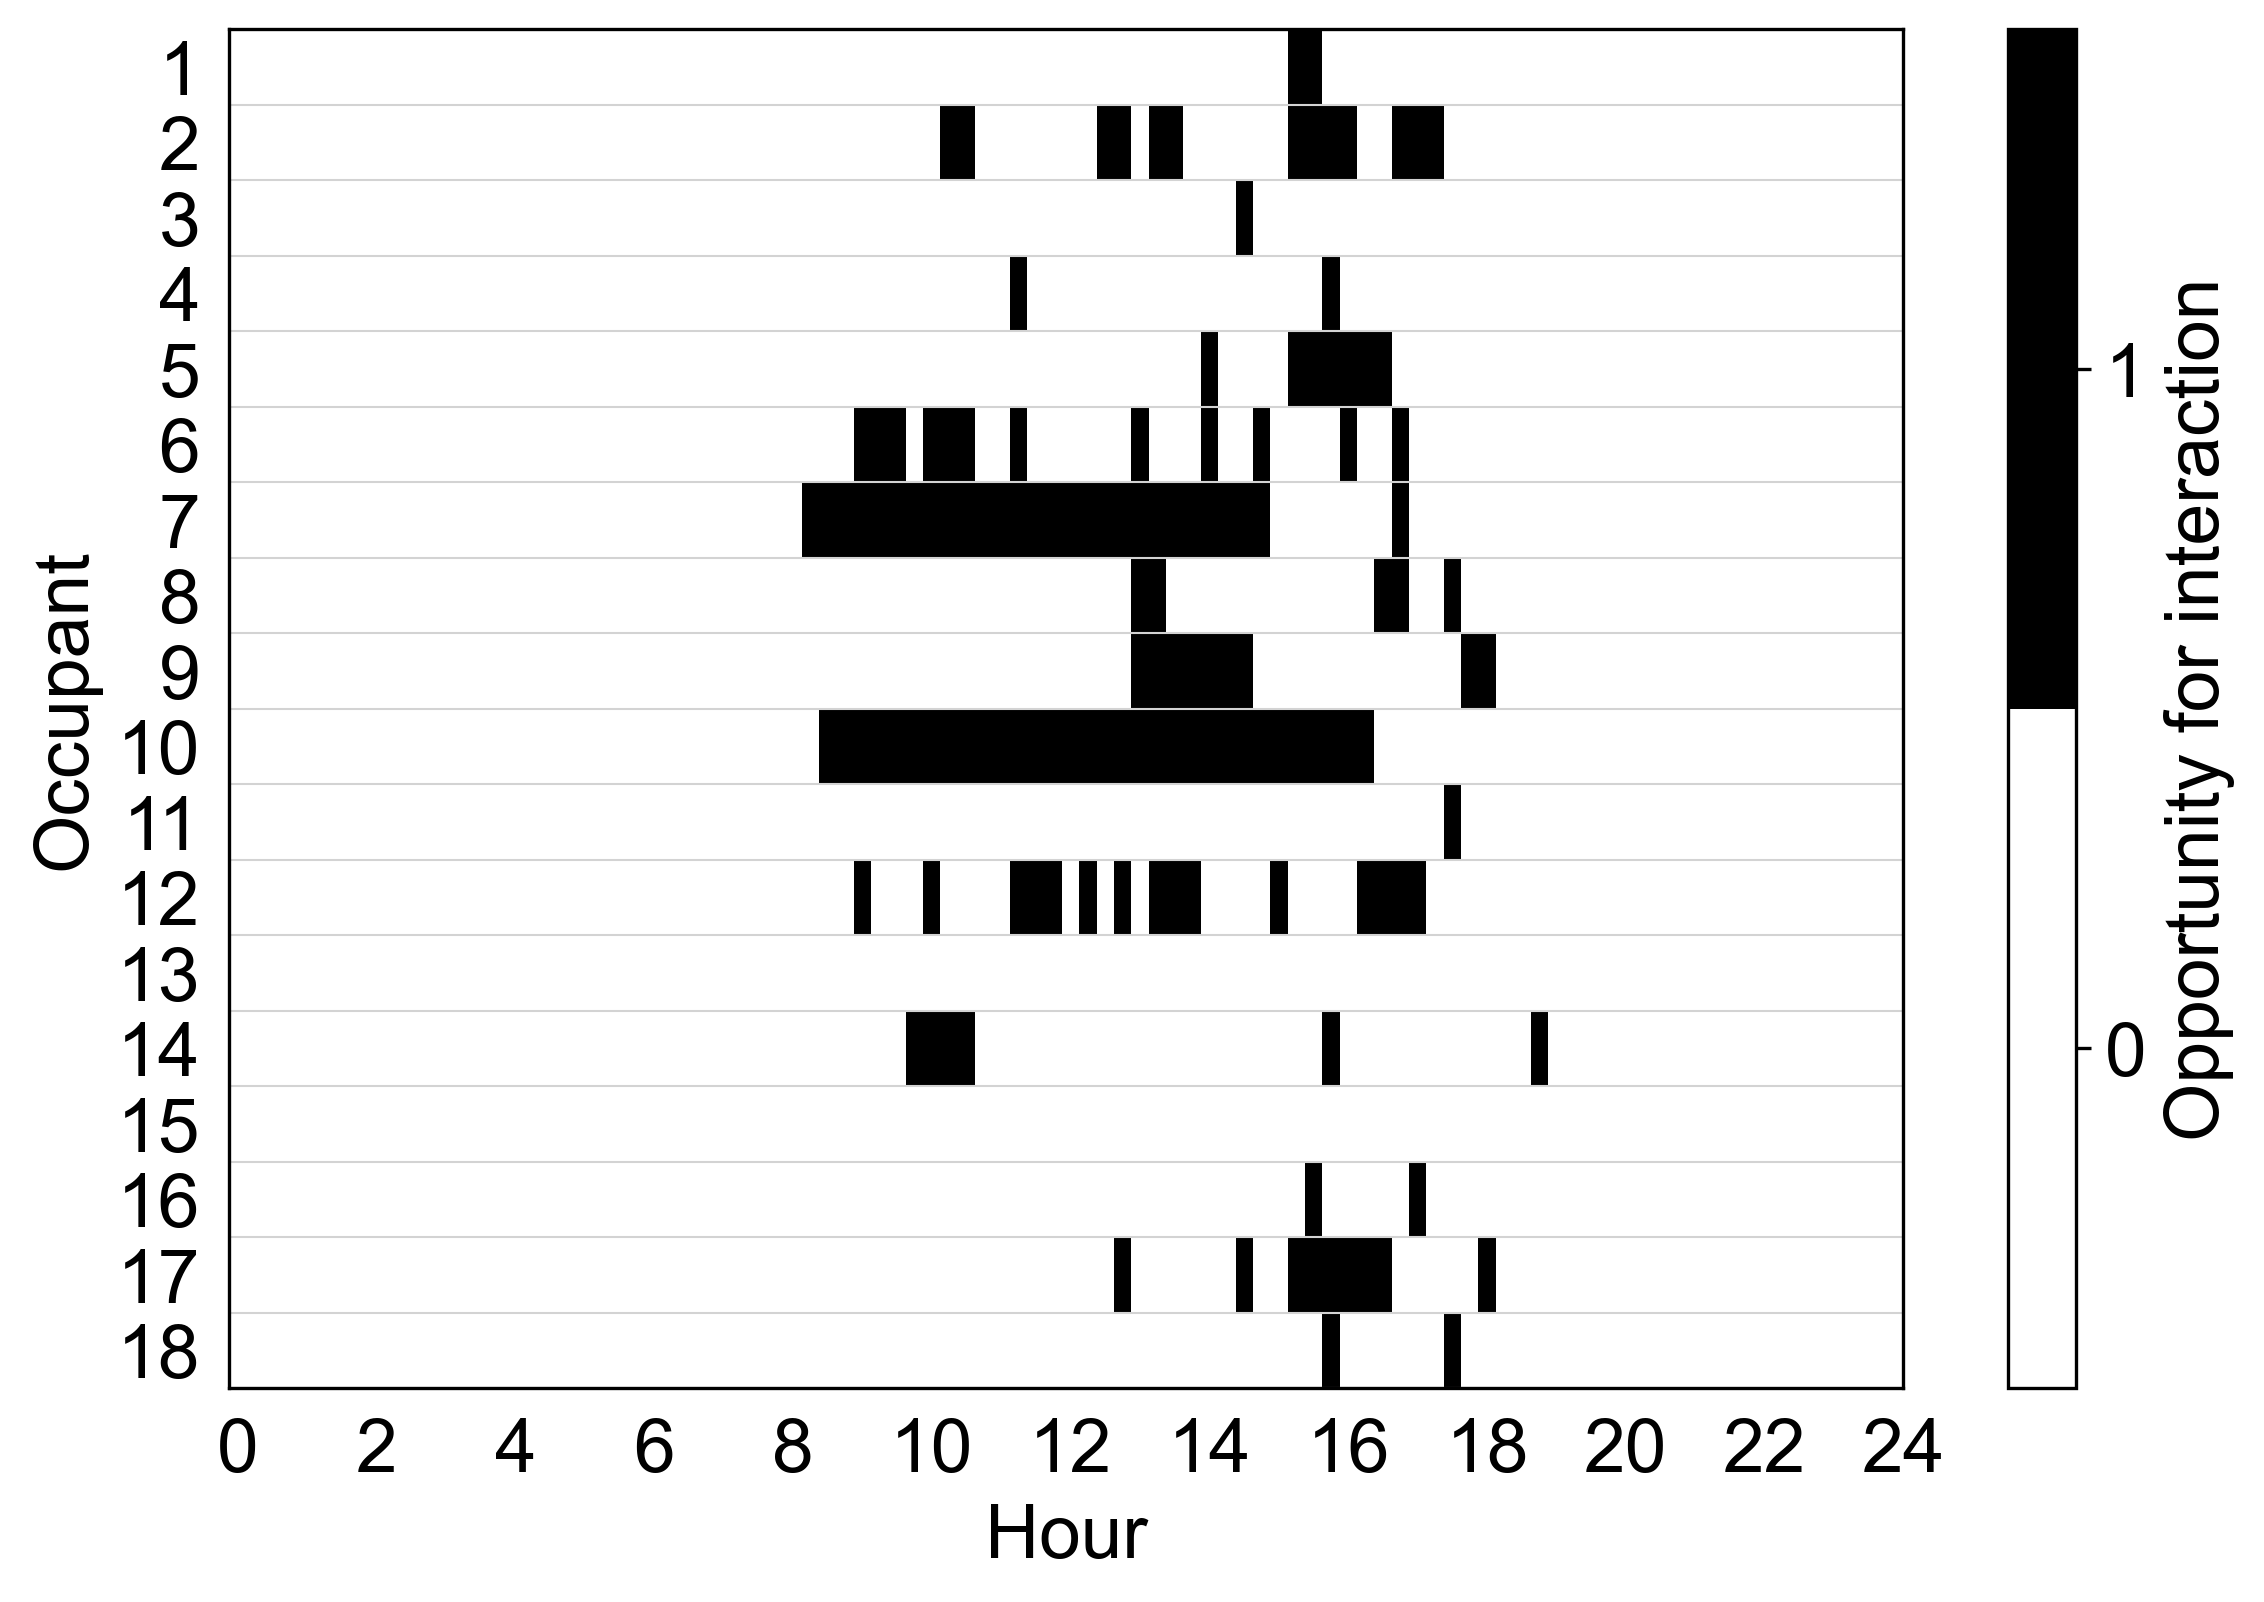

In [112]:
plt.rcParams.update({'font.size': 18})
heatdf = opportunity_vecs[0:18]

fig = plt.figure(figsize=(9,6), dpi=300)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Occupant')
ax.set_yticks(range(18))
ax.set_yticklabels(range(1,19))
x_axis_labels = []
for i in range(0,97):
    if i % 8 == 0:
        x_axis_labels.append(str(int(i/4)))
    else:
        x_axis_labels.append('')
im = plt.imshow(heatdf, cmap=plt.cm.get_cmap('gray_r', 2), aspect='auto', origin='upper', norm=None)
ax.set_xlabel('Hour')
ax.set_xticks(range(0,97))
ax.set_xticklabels(x_axis_labels)
ax.tick_params(bottom=False, left=False)
# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=[0,1], label='Opportunity for interaction')

for i in range(18):
    plt.axhline(y=i+0.5, color='lightgray', linewidth=0.5)

# Set the clim so that labels are centered on each block
plt.clim(-0.5, 1.5)

#fig.colorbar(im, label='Activity state')
plt.savefig('heatmap-interactions.tiff', dpi=300, bbox_inches='tight')
plt.show()

### Run interaction model over entire dataset

The following is custom code for the Berkeley data that  adjusts for the spatial rearrangements that ocurred over the data collection period. In the absence of sptial rearrangements, you only need to run the `interaction_matrix` function once.

In [81]:
import src.interaction_model as im
# Data segment 1: 08-09 to 10-09 (61 days) -- all occupants
overlaps1, similarities1 = im.interaction_matrix(classified['2018-08-09':'2018-10-09'])
# Data segment 2: 10-09 to 04-24 (197 days) -- occupant 10 gone
overlaps2, similarities2 = im.interaction_matrix(classified['2018-10-09':'2019-04-24'])
# Data segment 3: 04-24 to 06-17 (54 days) -- occupant 5 gone, occupant 10 gone
overlaps3, similarities3 = im.interaction_matrix(classified['2019-04-24':'2019-06-17'])
# Data segment 4: 06-17 to 08-09 (53 days) -- occupants 5 gone, occupant 10 in space 13, occupant 13 gone 
overlaps4, similarities4 = im.interaction_matrix(classified['2019-06-17':'2019-08-09'])

In [82]:
# Adjust similarity calculations for different data segments
similarities1_2 = (similarities1 + similarities2)/(61+197)
similarities1_2[9,:] = similarities1[9,:]/61
similarities1_2[:,9] = similarities1[:,9]/61
similarities1_3 = (similarities1_2*(61+197) + similarities3)/(61+197+54)
similarities1_3[4,:] = similarities1_2[4,:]
similarities1_3[:,4] = similarities1_2[:,4]
similarities1_3[9,:] = similarities1_2[9,:]
similarities1_3[:,9] = similarities1_2[:,9]
similarities = (similarities1_3*(61+197+54) + similarities4)/365
similarities[4,:] = similarities1_2[4,:]
similarities[:,4] = similarities1_2[:,4]
similarities[:,9] = (similarities1_2[:,9]*(61) + similarities4[:,12])/(61+53)
similarities[9,:] = (similarities1_2[9,:]*(61) + similarities4[12,:])/(61+53)
similarities[9,9] = 0
similarities[:,12] = similarities1_3[:,12]
similarities[12,:] = similarities1_3[12,:]
similarities = similarities[:18,:18]

### Visualize inferred network as a heatmap of the adjacency matrix

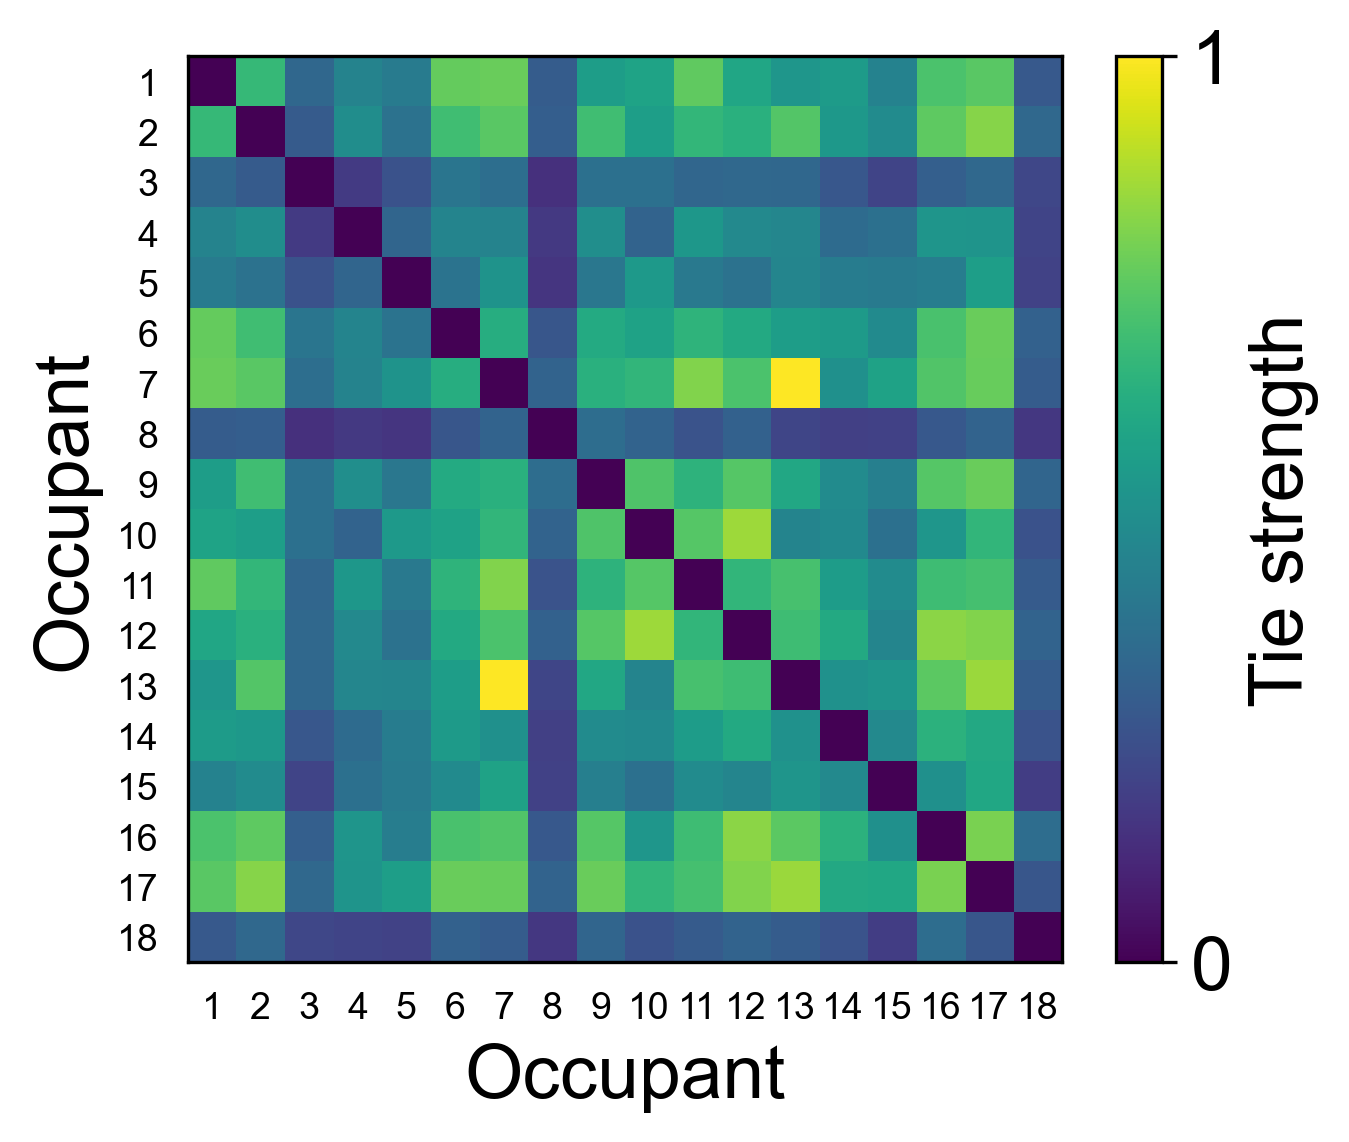

In [129]:
fig = plt.figure(figsize=(4.7,4), dpi=300)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Occupant')
ax.set_yticks(range(0,18))
ax.set_yticklabels(range(1,19), fontsize=9)
ax.set_xlabel('Occupant')
ax.set_xticks(range(0,18))
ax.set_xticklabels(range(1,19), fontsize=9)
ax.tick_params(bottom=False, left=False)
heatdf = copy.copy(similarities)
heatdf = (heatdf - heatdf.min()) / (heatdf.max() - heatdf.min())
im = plt.imshow(heatdf, cmap='viridis', aspect='auto', origin='upper')
plt.colorbar(ticks=[0,1], label='Tie strength')
plt.savefig('network-heatmap.tiff', dpi=300, bbox_inches='tight')
plt.show()

interaction_adj = similarities
%Rpush interaction_adj

In [84]:
%%R
write.csv(interaction_adj,'data/graphs/interaction-adj.csv', row.names=FALSE)

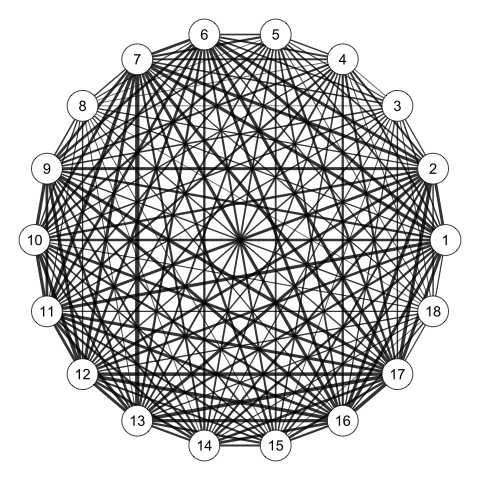

In [134]:
%%R
library(igraph)
interaction_graph <- graph_from_adjacency_matrix(interaction_adj, mode='undirected', weighted=TRUE)

# Only delete edges for plotting purposes!
# Comment following lines when saving the full graph
# interaction_graph <- delete_edges(interaction_graph, E(interaction_graph)[weight<.062])
# print(edge_density(interaction_graph))

lo <- layout.circle(interaction_graph)

# When plotting the graph, use the threshold line above
# png(width=1000, height=1000, res=150, file='interaction.png')
par(mar=c(0.1,0.1,0.1,0.1))
plot(interaction_graph, layout=lo, edge.width=E(interaction_graph)$weight*50, 
     vertex.label.cex=1.2,
     vertex.label.family='Arial',
     vertex.label.color='black',
     vertex.color='white',
     vertex.frame.color='black',
     edge.color=adjustcolor('black',.8),
     edge.arrow.mode=0,
    )

# Make sure when saving the graph, the edges have not been deleted above
write.csv(as_adj(interaction_graph, attr='weight', sparse=FALSE), 'data/graphs/interaction-adj.csv', row.names=FALSE)